# Simple Neural Network Model with different inputs

Input: testing different inputs

Output: optimal max-shape portfolio with normal restrictions for the next period

## Data Pre-processing

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.regularizers import L2

from helper_functions import train_and_evaluate_model

In [15]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [16]:
data_provider = DataProvider()

df_countries, benchmark = data_provider.get_etf_data()
acwi_weights = data_provider.get_acwi_weights()

In [17]:
days_to_recalculate = data_provider.get_days_to_recalculate()

# Start after 1 year to have enough historic data for first calculated period
days_to_recalculate = days_to_recalculate.iloc[12:]
days_to_recalculate = pd.DatetimeIndex(days_to_recalculate)
days_to_recalculate

DatetimeIndex(['2000-01-04', '2000-02-04', '2000-03-06', '2000-04-04',
               '2000-05-04', '2000-06-06', '2000-07-05', '2000-08-04',
               '2000-09-06', '2000-10-04',
               ...
               '2023-03-03', '2023-04-06', '2023-05-04', '2023-06-06',
               '2023-07-06', '2023-08-03', '2023-09-06', '2023-10-05',
               '2023-11-03', '2023-12-05'],
              dtype='datetime64[ns]', name='Days to rebalance', length=288, freq=None)

Preparing outputs common for all models

In [18]:
os.chdir(os.path.expanduser('../optimization'))

from PortfolioOptimizer import PortfolioOptimizer

In [19]:
y = []
for i in range(0,len(days_to_recalculate)):
    if i == len(days_to_recalculate) - 1:
        data_period = df_countries.loc[
            days_to_recalculate[i]:]
    else:
        data_period = df_countries.loc[
            days_to_recalculate[i]:days_to_recalculate[i+1]]
    i += 1

    year_str = str(data_period.index[0].year)
    acwi_weights_year = acwi_weights.loc[year_str]

    optimizer = PortfolioOptimizer()
    w, constraints = optimizer.get_normal_constraints(acwi_weights_year)
    optimal_portfolio = optimizer.get_optimal_portfolio(
        data_period, w, constraints)
    y.append(optimal_portfolio.values)

y = np.array(y)
y.shape

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


(288, 27)

In [20]:
val_split = int(0.7 * y.shape[0])
test_split = int(0.8 * y.shape[0])

# Train
dates_for_training = days_to_recalculate[:val_split]
y_train = y[:val_split]

# Validation
dates_for_validation = days_to_recalculate[val_split:test_split]
y_val = y[val_split:test_split]

# Test
dates_for_test = days_to_recalculate[test_split:]
y_test = y[test_split:]

In [21]:
os.chdir(os.path.expanduser('../data'))

## Defining models for different inputs

### DNN Model with a single fixed weight composite indicators

In [22]:
x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_simple_composite_indicator(
        date, periods=6)
    x.append(indicators.values)

x_simple_composite_indicator = np.array(x)

x_train_simple_composite_indicator = x_simple_composite_indicator[:val_split]
x_val_simple_composite_indicator = x_simple_composite_indicator[val_split:test_split]
x_test_simple_composite_indicator = x_simple_composite_indicator[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         2,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.9000 - val_loss: 2.6565 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5813 - val_loss: 2.3581 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2891 - val_loss: 2.0871 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0246 - val_loss: 1.8427 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7864 - val_loss: 1.6236 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5729 - val_loss: 1.4280 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3828 - val_loss: 1.2539 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2135 - val_loss: 1.0992 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0632 - val_loss: 0.9621 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

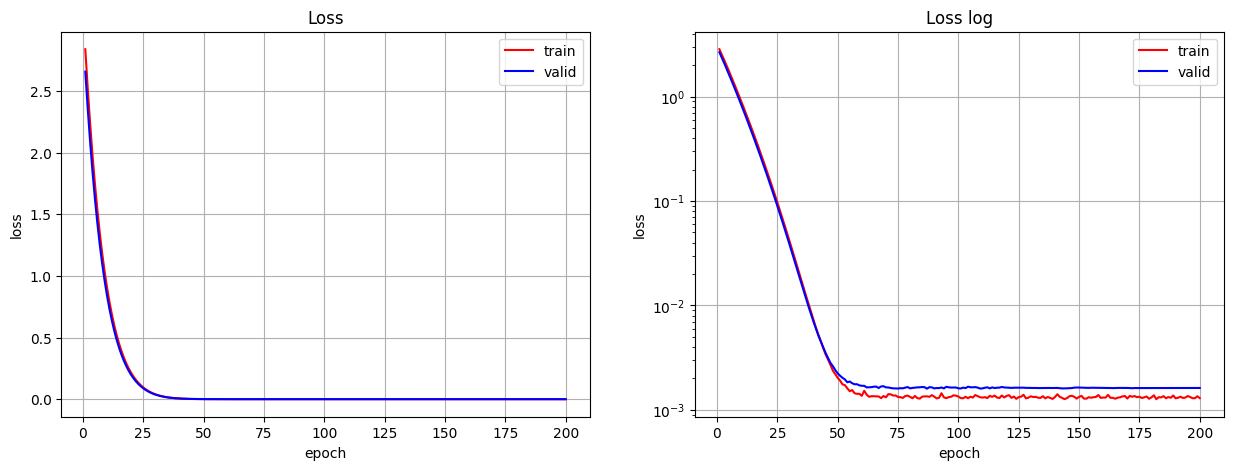

In [23]:
model_dnn_simple_composite_indicator = Sequential((
    Flatten(input_shape=x_train_simple_composite_indicator.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_simple_composite_indicator, 
                         x_train_simple_composite_indicator, y_train,
                         x_val_simple_composite_indicator, y_val, 
                         x_test_simple_composite_indicator, y_test)

### DNN Model with a single Manufacturing PMI indicator

In [24]:
indicator = 'Manufacturing PMI'
x = []
for date in days_to_recalculate:
    df = data_provider.get_key_indicator_values(indicator)
    df_normalized = data_provider.normilize_dataframe(df)
    df_last_values = data_provider.get_latest_data(
        indicator, df_normalized, date, periods=6)
    x.append(df_last_values.values)

x_manufacturing_pmi = np.array(x)

x_train_manufacturing_pmi = x_manufacturing_pmi[:val_split]
x_val_manufacturing_pmi = x_manufacturing_pmi[val_split:test_split]
x_test_manufacturing_pmi = x_manufacturing_pmi[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         2,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 2.7568 - val_loss: 2.5217 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.4486 - val_loss: 2.2339 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.1674 - val_loss: 1.9734 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9129 - val_loss: 1.7392 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6850 - val_loss: 1.5299 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4815 - val_loss: 1.3434 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2999 - val_loss: 1.1779 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1394 - val_loss: 1.0312 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9969 - val_loss: 0.9014 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━

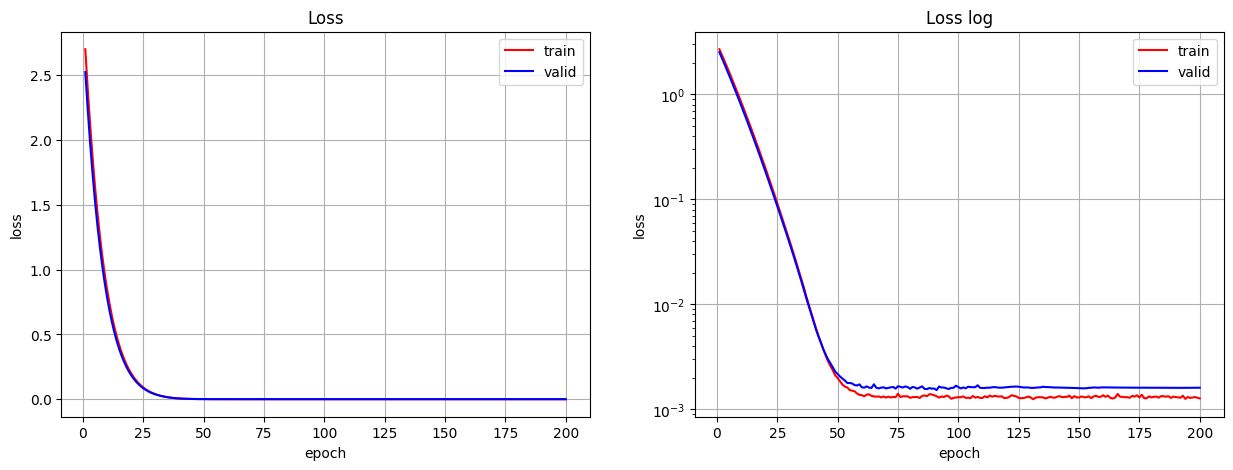

In [25]:
model_dnn_manufacturing_pmi = Sequential((
    Flatten(input_shape=x_train_manufacturing_pmi.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_manufacturing_pmi, 
                         x_train_manufacturing_pmi, y_train,
                         x_val_manufacturing_pmi, y_val, 
                         x_test_manufacturing_pmi, y_test)

### DNN Model with 6 separate indicators

In [26]:
x = []
for date in days_to_recalculate:
    indicators_arr = []
    for indicator in data_provider.key_indicators:
        df = data_provider.get_key_indicator_values(indicator)
        df_normalized = data_provider.normilize_dataframe(df)
        indicators_arr.append(data_provider.get_latest_data(
            indicator, df_normalized, date, periods=6).values)

    concat_indicators = np.concatenate(indicators_arr, axis=1)
    x.append(concat_indicators)

x_separate_indicators = np.array(x)

x_train_separate_indicators = x_separate_indicators[:val_split]
x_val_separate_indicators = x_separate_indicators[val_split:test_split]
x_test_separate_indicators = x_separate_indicators[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 972)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │        15,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,027 (62.61 KB)

 Trainable params: 16,027 (62.61 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.9811 - val_loss: 2.4031 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2414 - val_loss: 1.7770 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6490 - val_loss: 1.2875 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1890 - val_loss: 0.9151 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8407 - val_loss: 0.6387 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5840 - val_loss: 0.4381 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3983 - val_loss: 0.2957 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2675 - val_loss: 0.1968 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1767 - val_loss: 0.1293 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

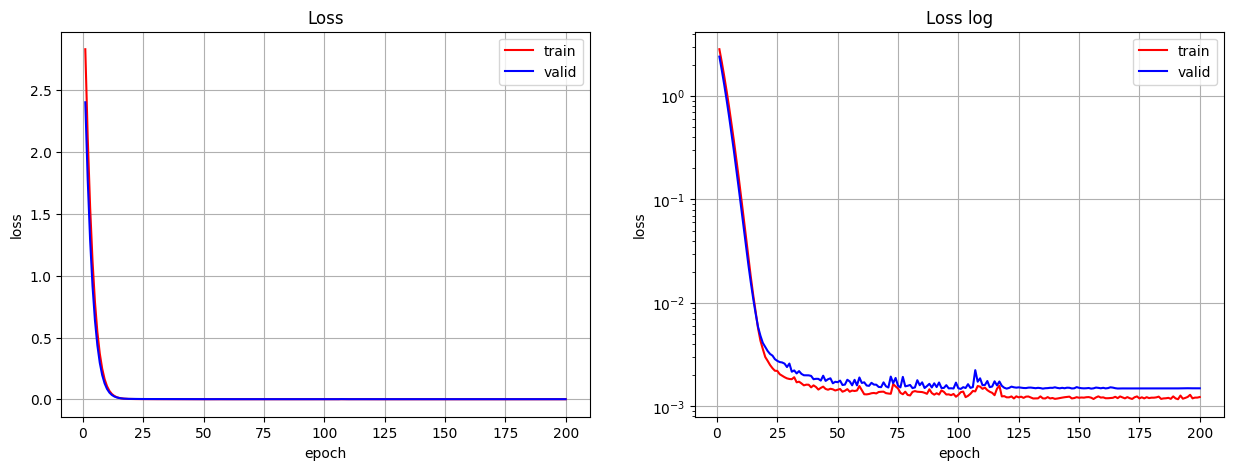

In [27]:
model_dnn_separate_indicators = Sequential((
    Flatten(input_shape=x_train_separate_indicators.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_separate_indicators, 
                         x_train_separate_indicators, y_train,
                         x_val_separate_indicators, y_val, 
                         x_test_separate_indicators, y_test)

### DNN Model with 14 separate indicators

In [28]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

x = []
for date in days_to_recalculate:
    indicators_arr = []
    for indicator in all_indicators:
        df = data_provider.get_key_indicator_values(indicator)
        df_normalized = data_provider.normilize_dataframe(df)
        indicators_arr.append(data_provider.get_latest_data(
            indicator, df_normalized, date, periods=6).values)

    concat_indicators = np.concatenate(indicators_arr, axis=1)
    x.append(concat_indicators)

x_separate_all_indicators = np.array(x)

x_train_separate_all_indicators = x_separate_all_indicators[:val_split]
x_val_separate_all_indicators = x_separate_all_indicators[val_split:test_split]
x_test_separate_all_indicators = x_separate_all_indicators[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 2268)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │        36,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,763 (143.61 KB)

 Trainable params: 36,763 (143.61 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.8801 - val_loss: 2.0537 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8419 - val_loss: 1.2596 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1154 - val_loss: 0.7310 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6392 - val_loss: 0.4008 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3451 - val_loss: 0.2075 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1755 - val_loss: 0.1020 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0849 - val_loss: 0.0487 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0390 - val_loss: 0.0239 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0183 - val_loss: 0.0134 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

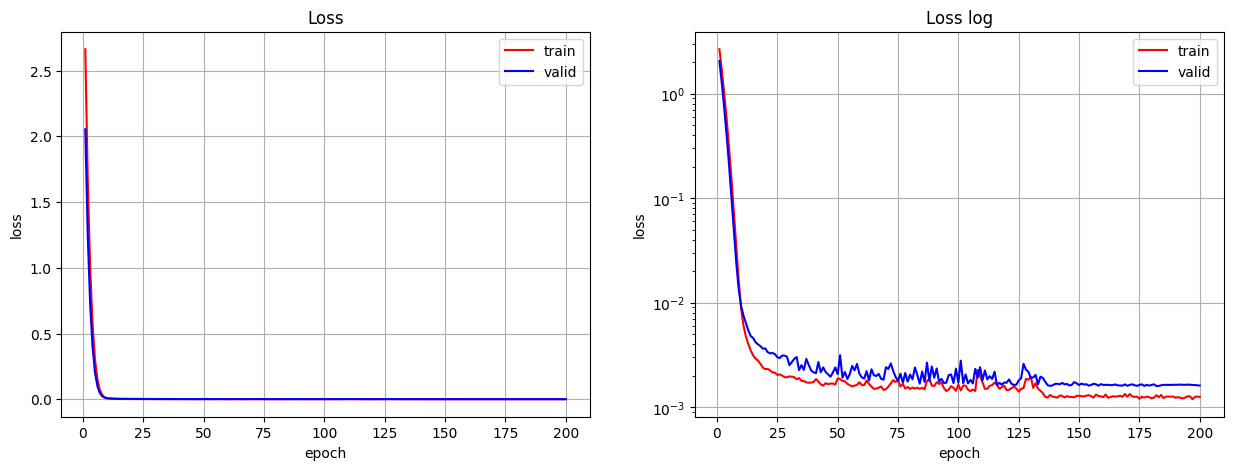

In [29]:
model_dnn_separate_all_indicators = Sequential((
    Flatten(input_shape=x_train_separate_all_indicators.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_separate_all_indicators, 
                         x_train_separate_all_indicators, y_train,
                         x_val_separate_all_indicators, y_val, 
                         x_test_separate_all_indicators, y_test)

### DNN Model with single principal component from PCA

In [52]:
x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=6, indicators=data_provider.key_indicators)
    x.append(indicators.values)

x_pca_component = np.array(x)

x_train_pca_component = x_pca_component[:val_split]
x_val_pca_component = x_pca_component[val_split:test_split]
x_test_pca_component = x_pca_component[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_9 (Flatten)             │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │         2,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.8014 - val_loss: 2.5633 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4896 - val_loss: 2.2718 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2046 - val_loss: 2.0076 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9470 - val_loss: 1.7697 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7150 - val_loss: 1.5568 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5081 - val_loss: 1.3670 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3237 - val_loss: 1.1983 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1600 - val_loss: 1.0487 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0148 - val_loss: 0.9163 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

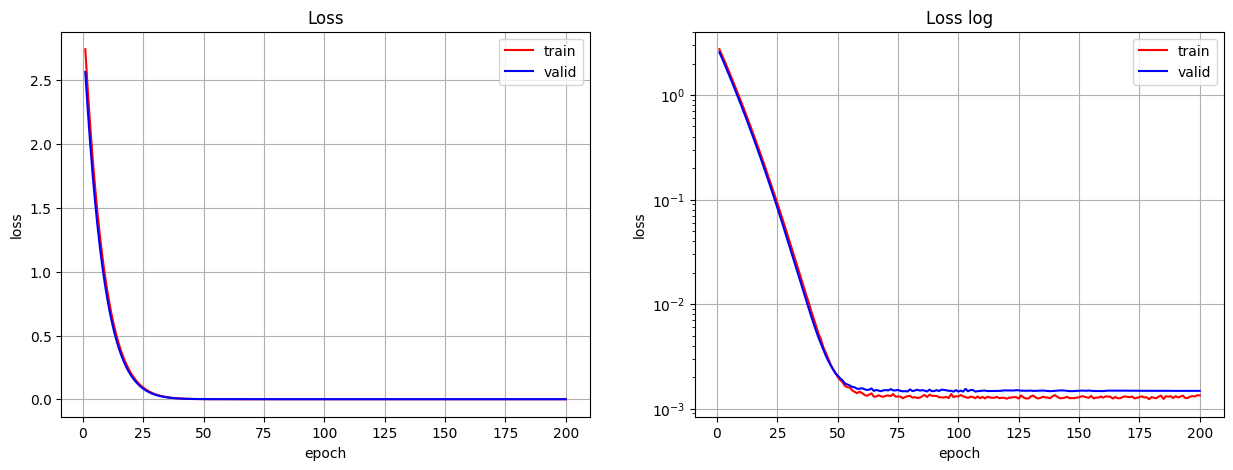

In [53]:
model_dnn_pca_component = Sequential((
    Flatten(input_shape=x_train_pca_component.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_pca_component, 
                         x_train_pca_component, y_train,
                         x_val_pca_component, y_val, 
                         x_test_pca_component, y_test)

### DNN Model with single principal component from PCA for all 14 indicators

In [54]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=6, indicators=all_indicators)
    x.append(indicators.values)

x_pca_component_all = np.array(x)

x_train_pca_component_all = x_pca_component_all[:val_split]
x_val_pca_component_all = x_pca_component_all[val_split:test_split]
x_test_pca_component_all = x_pca_component_all[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)            │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │         2,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.8815 - val_loss: 2.6357 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5646 - val_loss: 2.3398 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2745 - val_loss: 2.0711 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0120 - val_loss: 1.8290 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7758 - val_loss: 1.6119 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5642 - val_loss: 1.4181 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3754 - val_loss: 1.2455 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2076 - val_loss: 1.0921 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0584 - val_loss: 0.9562 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

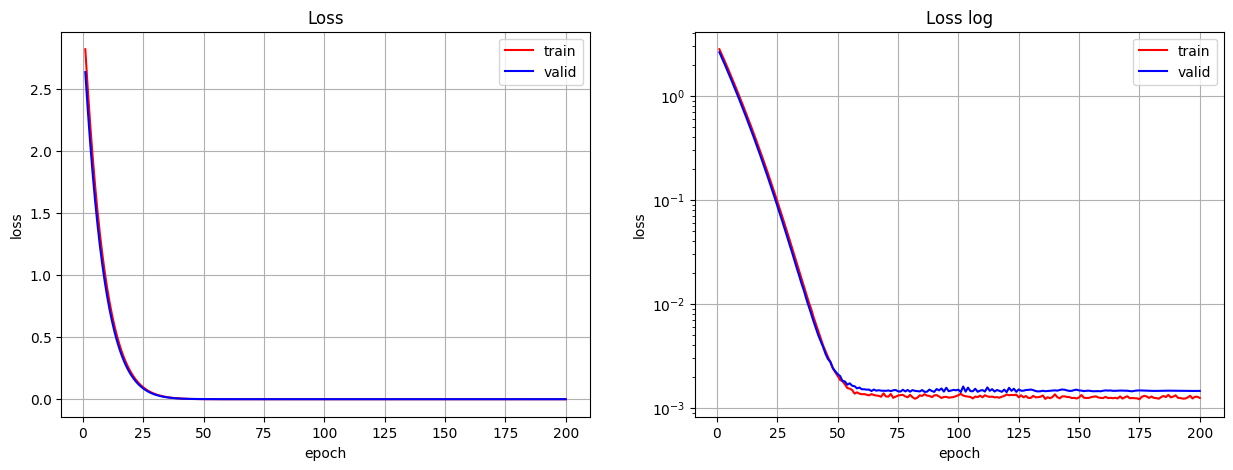

In [55]:
model_dnn_pca_component_all = Sequential((
    Flatten(input_shape=x_train_pca_component_all.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_pca_component_all, 
                         x_train_pca_component_all, y_train,
                         x_val_pca_component_all, y_val, 
                         x_test_pca_component_all, y_test)

### DNN Model with 2 principal components from PCA for all 14 indicators

In [56]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators
indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=6, indicators=all_indicators, n_components=2)
indicators

,United States,Japan,United Kingdom,Canada,France,Switzerland,Germany,Australia,Netherlands,Sweden,...,Norway,China,Taiwan,India,Korea,Brazil,Russia,South Africa,Mexico,Malaysia
0,0.559255,0.189346,-0.532612,0.248106,0.351550,-0.175868,0.405751,0.177238,0.565847,-0.676383,...,0.026334,-0.842594,-1.813794,-0.161632,0.580790,0.234933,-0.955897,0.430494,-0.383783,-0.699511
1,-0.030733,-2.844177,0.636891,-0.276331,-0.566876,0.105059,0.450560,-3.112750,-0.888248,-0.947001,...,2.032281,0.618277,-0.095603,1.453051,5.650637,-3.685916,2.024295,3.254976,-0.228800,0.445386
2,0.537840,0.053359,-0.591140,0.331185,0.149249,-0.178571,0.317689,0.207813,0.734823,-0.462199,...,0.000286,-0.177463,-1.359978,0.014169,0.623818,0.295454,-0.771533,0.199236,-0.550311,-0.494018
3,0.076762,-2.419773,1.486999,-0.338666,-0.635920,-0.043016,0.288460,-3.258815,-1.005142,-1.050299,...,1.942338,0.788088,0.142879,1.598991,5.505495,-3.821034,2.080968,3.576024,-0.196122,0.410623
4,0.740348,0.423845,-0.517850,0.209657,-0.034108,-0.339945,0.448702,0.310948,0.594093,-0.614662,...,0.175426,-0.770436,-0.776509,0.216619,0.627058,0.202681,-0.763045,0.068220,-0.556889,-0.826736
5,-0.128096,-1.727411,1.560886,-0.314939,-0.809187,0.065920,0.468561,-3.330756,-0.171238,-0.875769,...,1.883866,0.994722,0.832140,1.794106,5.523551,-3.664748,2.262579,3.741131,-0.522316,0.313881
6,0.912302,0.435736,-0.820684,0.081281,0.130563,-0.453722,0.202069,-0.055592,0.740777,-0.397009,...,-0.027359,-0.951316,-1.566550,0.234762,0.527635,0.644246,-0.946814,-0.016927,-0.568706,-0.555731
7,0.197392,-2.569126,0.977808,-0.401832,-0.855124,0.058174,0.404745,-3.504078,-0.905235,-0.644291,...,1.939289,1.253478,1.684288,2.391831,5.547273,-3.229258,2.259979,3.910547,-0.637498,0.176706
8,0.944454,0.585313,-0.928744,-0.117758,0.216453,-0.258533,0.030419,-0.205625,0.191944,-0.901635,...,-0.158320,-0.867457,-1.857437,0.379653,0.519871,0.427631,-1.072900,-0.113674,-0.596296,-0.778450
9,-0.298051,-2.490891,0.942829,0.021818,-0.806295,-0.123902,0.321724,-2.892564,-0.607447,-0.629255,...,1.978645,1.192687,2.254461,2.546163,5.607331,-3.567914,2.237384,3.826590,-0.641822,0.111285


In [57]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=6, indicators=all_indicators, n_components=2)
    x.append(indicators.values)

x_pca_two_components = np.array(x)

x_train_pca_two_components = x_pca_two_components[:val_split]
x_val_pca_two_components = x_pca_two_components[val_split:test_split]
x_test_pca_two_components = x_pca_two_components[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_11 (Flatten)            │ (None, 324)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │         5,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,659 (22.11 KB)

 Trainable params: 5,659 (22.11 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.9814 - val_loss: 2.6373 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5333 - val_loss: 2.2293 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1377 - val_loss: 1.8733 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7939 - val_loss: 1.5660 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4975 - val_loss: 1.3032 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2443 - val_loss: 1.0802 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0303 - val_loss: 0.8919 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8501 - val_loss: 0.7339 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6980 - val_loss: 0.6017 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

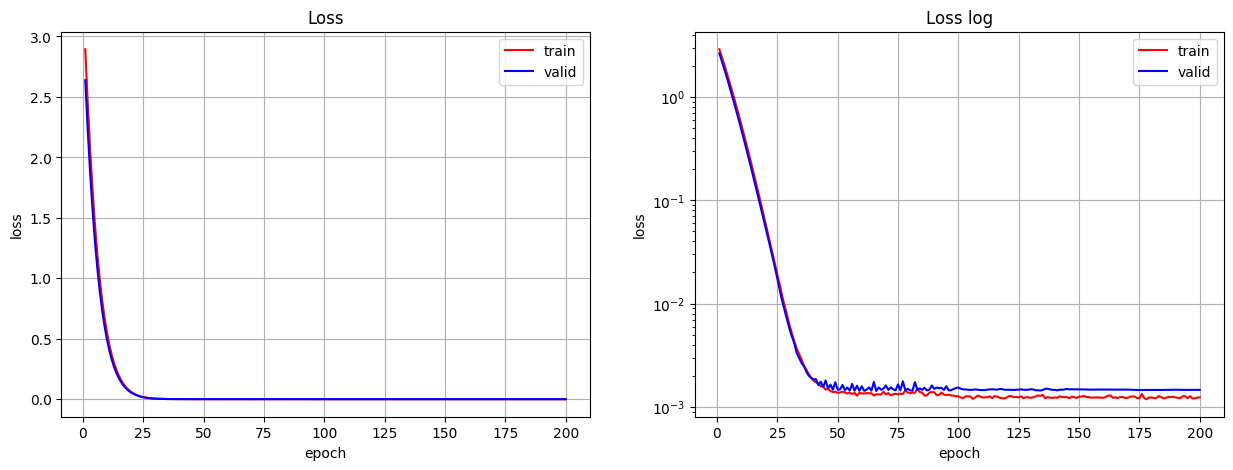

In [58]:
model_dnn_pca_two_components = Sequential((
    Flatten(input_shape=x_train_pca_two_components.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_pca_two_components, 
                         x_train_pca_two_components, y_train,
                         x_val_pca_two_components, y_val, 
                         x_test_pca_two_components, y_test)

### DNN Model with 3 principal components from PCA for all 14 indicators

In [59]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=6, indicators=all_indicators, n_components=3)
    x.append(indicators.values)

x_pca_three_components = np.array(x)

x_train_pca_three_components = x_pca_three_components[:val_split]
x_val_pca_three_components = x_pca_three_components[val_split:test_split]
x_test_pca_three_components = x_pca_three_components[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_12 (Flatten)            │ (None, 486)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │         7,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,251 (32.23 KB)

 Trainable params: 8,251 (32.23 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.0123 - val_loss: 2.5906 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4666 - val_loss: 2.1050 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9995 - val_loss: 1.6950 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6064 - val_loss: 1.3540 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2806 - val_loss: 1.0739 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0135 - val_loss: 0.8461 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7969 - val_loss: 0.6625 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6229 - val_loss: 0.5158 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4838 - val_loss: 0.3993 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

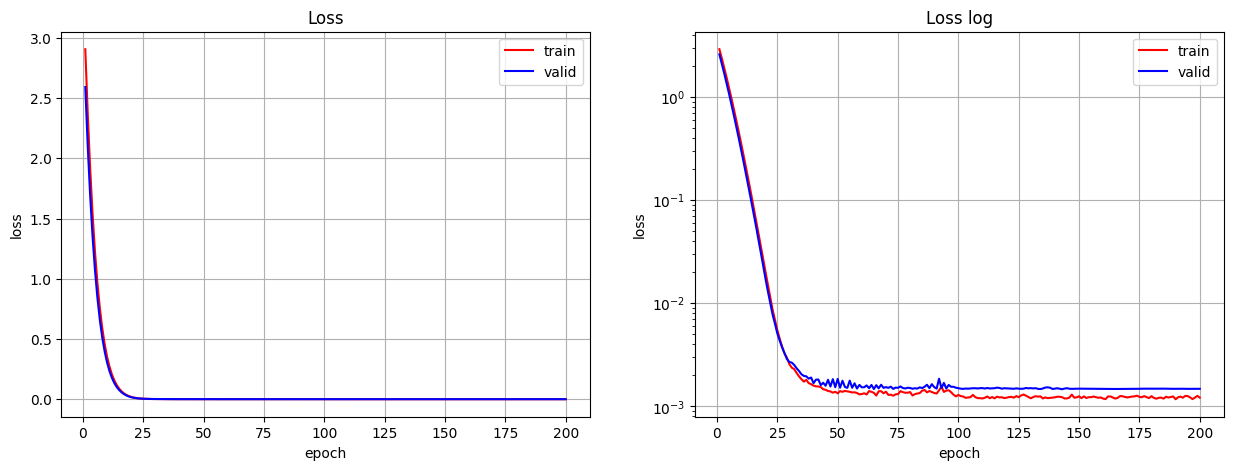

In [60]:
model_dnn_pca_three_components = Sequential((
    Flatten(input_shape=x_train_pca_three_components.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_pca_three_components, 
                         x_train_pca_three_components, y_train,
                         x_val_pca_three_components, y_val, 
                         x_test_pca_three_components, y_test)

## Backtesting

In [61]:
from helper_functions import calculate_returns_for_model, calculate_metrics

In [62]:
benchmark_test = benchmark[dates_for_test[0]:]
benchmark_returns = np.log(benchmark_test).diff().dropna()
cum_benchmark_returns = (1 + benchmark_returns).cumprod() - 1
cum_benchmark_returns.loc[dates_for_test[0]] = 0
cum_benchmark_returns.sort_index(inplace=True)

In [63]:
selected_countries = df_countries.columns
days_to_rebalance = dates_for_test.insert(29, df_countries.index.values[-1])
df_prices_test = df_countries[dates_for_test[0]:]
df_returns_test = np.log(df_prices_test).diff().fillna(0)

In [64]:
(total_ret_simple_composite_indicator,
 cum_total_ret_simple_composite_indicator) = calculate_returns_for_model(
    model_dnn_simple_composite_indicator, x_test_simple_composite_indicator,
    dates_for_test, df_returns_test, selected_countries)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


In [65]:
(total_ret_manufacturing_pmi, 
 cum_total_ret_manufacturing_pmi) = calculate_returns_for_model(
    model_dnn_manufacturing_pmi, x_test_manufacturing_pmi,
    dates_for_test, df_returns_test, selected_countries)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


In [66]:
(total_ret_separate_indicators, 
 cum_total_ret_separate_indicators) = calculate_returns_for_model(
    model_dnn_separate_indicators, x_test_separate_indicators,
    dates_for_test, df_returns_test, selected_countries)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


In [67]:
(total_ret_separate_all_indicators, 
 cum_total_ret_separate_all_indicators) = calculate_returns_for_model(
    model_dnn_separate_all_indicators, x_test_separate_all_indicators,
    dates_for_test, df_returns_test, selected_countries)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


In [68]:
(total_ret_pca_component, 
 cum_total_ret_pca_component) = calculate_returns_for_model(
    model_dnn_pca_component, x_test_pca_component,
    dates_for_test, df_returns_test, selected_countries)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [69]:
(total_ret_pca_component_all, 
 cum_total_ret_pca_component_all) = calculate_returns_for_model(
    model_dnn_pca_component_all, x_test_pca_component_all,
    dates_for_test, df_returns_test, selected_countries)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [70]:
(total_ret_pca_two_components, 
 cum_total_ret_pca_two_components) = calculate_returns_for_model(
    model_dnn_pca_two_components, x_test_pca_two_components,
    dates_for_test, df_returns_test, selected_countries)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [71]:
(total_ret_pca_three_components, 
 cum_total_ret_pca_three_components) = calculate_returns_for_model(
    model_dnn_pca_three_components, x_test_pca_three_components,
    dates_for_test, df_returns_test, selected_countries)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


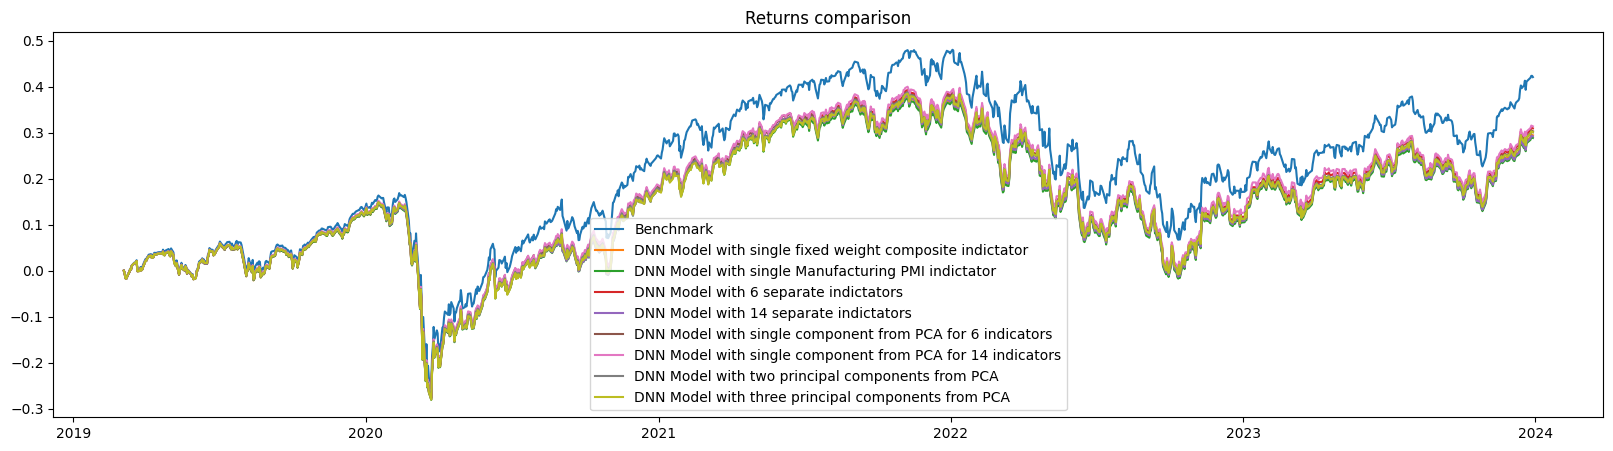

In [72]:
plt.figure(figsize=(20, 5))
plt.plot(cum_benchmark_returns, label='Benchmark')
plt.plot(cum_total_ret_simple_composite_indicator,
         label='DNN Model with single fixed weight composite indictator')
plt.plot(cum_total_ret_manufacturing_pmi,
         label='DNN Model with single Manufacturing PMI indictator')
plt.plot(cum_total_ret_separate_indicators,
         label='DNN Model with 6 separate indictators')
plt.plot(cum_total_ret_separate_all_indicators,
         label='DNN Model with 14 separate indictators')
plt.plot(cum_total_ret_pca_component,
         label='DNN Model with single component from PCA for 6 indicators')
plt.plot(cum_total_ret_pca_component_all,
         label='DNN Model with single component from PCA for 14 indicators')
plt.plot(cum_total_ret_pca_two_components,
         label='DNN Model with two principal components from PCA')
plt.plot(cum_total_ret_pca_three_components,
         label='DNN Model with three principal components from PCA')
plt.legend()
plt.title('Returns comparison')
plt.show()

In [73]:
df_results = pd.DataFrame(columns=['Annual Returns',
                                   'Annual Volatility',
                                   'Annual Sharpe Ratio'])

calculate_metrics(benchmark_returns, df_results, 'Benchmark')
calculate_metrics(total_ret_simple_composite_indicator, df_results,
                  'DNN Model with single fixed weight composite indictator')
calculate_metrics(total_ret_manufacturing_pmi, df_results,
                  'DNN Model with single Manufacturing PMI indictator')
calculate_metrics(total_ret_separate_indicators, df_results,
                  'DNN Model with 6 separate indictators')
calculate_metrics(total_ret_separate_all_indicators, df_results,
                  'DNN Model with 14 separate indictators')
calculate_metrics(total_ret_pca_component, df_results,
                  'DNN Model with single component from PCA for 6 indicators')
calculate_metrics(total_ret_pca_component_all, df_results,
                  'DNN Model with single component from PCA for 14 indicators')
calculate_metrics(total_ret_pca_two_components, df_results,
                  'DNN Model with two principal components from PCA')
calculate_metrics(total_ret_pca_three_components, df_results,
                  'DNN Model with three principal components from PCA')


df_results

,Annual Returns,Annual Volatility,Annual Sharpe Ratio
Benchmark,0.076754,0.203326,0.377494
DNN Model with single fixed weight composite indictator,0.054982,0.201113,0.273388
DNN Model with single Manufacturing PMI indictator,0.054018,0.200921,0.26885
DNN Model with 6 separate indictators,0.057526,0.201458,0.285549
DNN Model with 14 separate indictators,0.054595,0.201361,0.271129
DNN Model with single component from PCA for 6 indicators,0.056469,0.200185,0.282083
DNN Model with single component from PCA for 14 indicators,0.058267,0.200596,0.29047
DNN Model with two principal components from PCA,0.056065,0.20084,0.27915
DNN Model with three principal components from PCA,0.056147,0.201688,0.278384
